In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from PIL import Image
from collections import defaultdict
import pathlib

In [2]:
# loading data
DATA_DIR = "facial_expressions/data"
IMAGE_DIR = "facial_expressions/images"
data = pd.read_csv(f'{DATA_DIR}/legend.csv')
data['emotion'] = data['emotion'].str.lower()

In [3]:
# prepping training datasets
Y = np.array(data['emotion'])
X_temp = []
# ran into too many files open error: https://stackoverflow.com/questions/29234413/too-many-open-files-error-when-opening-and-loading-images-in-pillow
# find the minimum width and height and I can resize all images to that shape
min_width = 1000
min_height = 1000
for image in data['image']:
    temp = Image.open(IMAGE_DIR + '/' + image)
    keep = temp.copy().convert('L')
    min_width = min(min_width, keep.size[0])
    min_height = min(min_height, keep.size[1])
    X_temp.append(keep)
    temp.close()
# steps from Wikipedia: https://en.wikipedia.org/wiki/Eigenface
# all images should be resampled to a common pixel resolution and flatten
X = [np.asarray(image.resize((min_width, min_height))).flatten() for image in X_temp]
# spliting data in to training and validation sets
split_factor = 0.8
stop = int(split_factor * len(X))
Xtr,Xva = X[:stop],X[stop:]
Ytr,Yva = Y[:stop],Y[stop:]

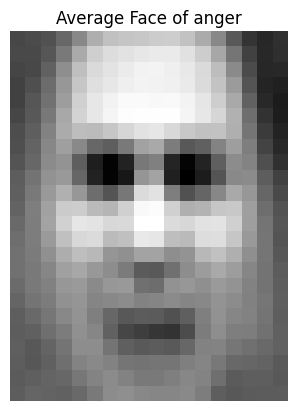

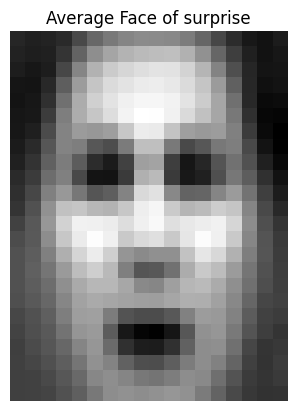

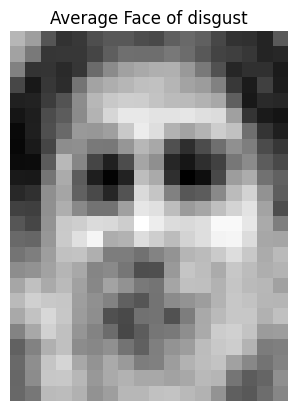

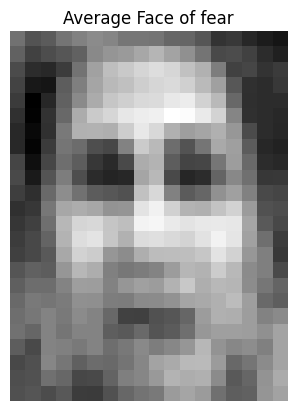

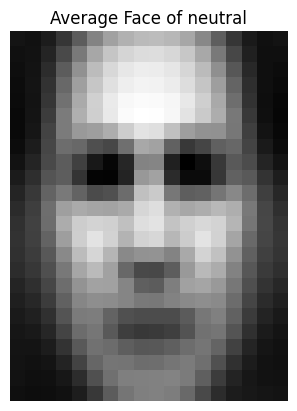

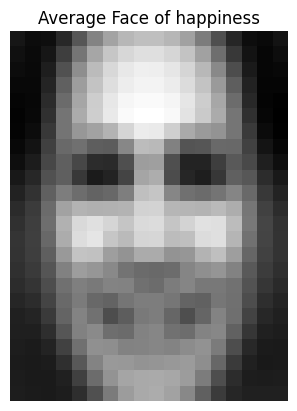

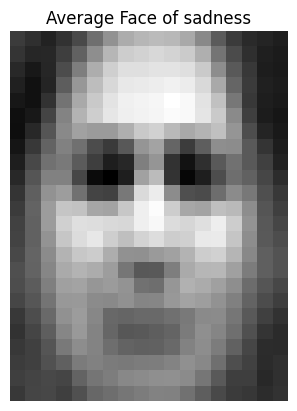

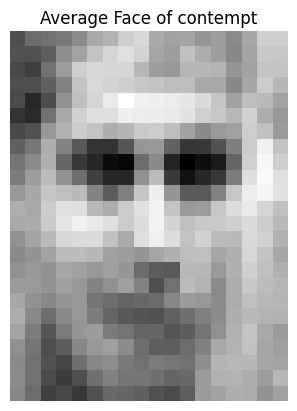

In [4]:
# Training
# Average Faces
# faces by emotions
faces_dict = defaultdict(list)
for i, image in enumerate(Xtr):
    faces_dict[Y[i]].append(image)
# average faces by emotions
average_faces = defaultdict(list)
for emotion,faces in faces_dict.items():
    average_faces[emotion] = np.mean(faces, 0)
    plt.figure()
    plt.title('Average Face of {}'.format(emotion))
    average_face_image = np.reshape(average_faces[emotion], (min_height, min_width))
    plt.imshow(average_face_image, cmap="gray")
    plt.axis('off')
    plt.show()

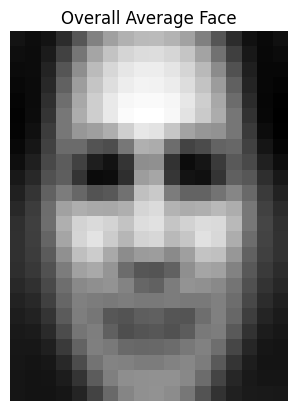

In [5]:
# calculates the mean/average face
average_face = np.mean(Xtr,0)
average_face_image = np.reshape(average_face, (min_height, min_width))
plt.figure()
plt.title('Overall Average Face')
plt.imshow(average_face_image, cmap="gray")
plt.axis('off')
plt.show()

In [6]:
# Eigenfaces
# subtract mean face from each original image in Xtr
Xtr -= average_face
# obtain the covariance matrix, S
S = np.cov(Xtr.T)
# obtain eigenvectors and eigenvalues from the covariance matrix
eigenvalues,eigenvectors = sp.linalg.eig(S)
# sort the eigenvalues in descending order and arrange eigenvectors accordingly.
# went to stackoverflow for help: https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

In [16]:
print(eigenvalues.shape)
print(eigenvectors.shape)
Xhat = eigenvalues.dot(eigenvectors)
print(Xhat.shape)
print(X[0])

(432,)
(432, 432)
(432,)
[198 198 200 200 205 191 144  93  69  66  72  97 144 190 198 192 192 192
 198 197 200 204 143  60  34  33  35  38  38  35  39  74 156 198 193 192
 203 199 204 127  35  33  39  37  39  42  44  40  37  34  41 123 196 193
 205 205 153  41  37  43  41  41  39  46  45  38  37  39  36  33 142 199
 207 197  69  31  39  56  63  53  53  55  51  61  63  43  39  32  69 189
 211 167  37  37  57 110 122 119 118 111 102 128 139 122  85  43  37 155
 214 142  31  44  92 132 130 126 127 129 131 140 151 160 150  94  38 136
 215 121  31  47  97 132 129 122 123 126 127 133 143 150 156 132  53 122
 218 112  31  59 106 125 125 120 124 131 127 132 144 153 160 133  52 117
 197 112  39 102 126 125 117 114 117 131 122 130 139 140 150 135  66 150
 105  92  72 135 116  88  64  63  78  89  98  84 103 106 134 145 104 141
 111  90  96 142 110  75  50  44  43  84 121  69  30  42  69 117 136 123
 129  78 111 151 154 139 114 110 118 138 159 146 107 110 137 155 135 124
 157 118 121 145 154 151 1

In [7]:
# only some eigenfaces are needed for certain variance
# variance = 0.99
# comp_eigen_sum = 0
# eigen_sum = np.sum(eigenvalues)
# # k = number of principal components to achieve the variance
# k = 1
# for i, eigenvalue in enumerate(eigenvalues):
#     comp_eigen_sum += eigenvalue
#     total_variance = comp_eigen_sum/eigen_sum
#     if total_variance > variance:
#         k += i
#         break
# print(k)